<a href="https://colab.research.google.com/github/ymuto0302/RW2025/blob/main/StockPrediction_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RNNを用いた株価予測

## 必要なライブラリのインポート

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch.utils.data import Dataset, DataLoader
import yfinance as yf
from datetime import datetime, timedelta

# デバイスの設定
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用デバイス: {device}")

使用デバイス: cpu


## データ取得 ＆ 前処理
- Yahoo Finance API を用いて実際の株価データを取得
- テクニカル指標: 移動平均，MACD，RSI，ボリンジャーバンドなど

### 本クラスの機能：
1. Yahoo Finance APIからの株価データ取得
1. テクニカル指標の計算
1. データの正規化処理
1. 特徴量の前処理

### 特徴量エンジニアリング
- 基本データ: Open, High, Low, Close, Volume
- 移動平均: MA_5 (5日移動平均), MA_10 (10日移動平均), MA_20 (20日移動平均), EMA_12 (12日指数移動平均), EMA_26  (26日指数移動平均)
- テクニカル: MACD (移動平均収束発散), MACD_signal (MACDシグナル線), RSI (相対力指数), BB_upper (ボリンジャーバンド上限), BB_middle (ボリンジャーバンド中央線), BB_lower (ボリンジャーバンド下限)
- 変化率: Price_change (価格変化率)， Volume_change(出来高変化率)
- 比率: High_Low_ratio(高値／安値比率)， Close_Open_ratio (終値／始値比率)


In [11]:
# データ取得・前処理
class StockDataProcessor:
    def __init__(self):
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.feature_scalers = {}

    # 株価データのダウンロード
    def download_stock_data(self, symbol='AAPL', period='2y'):
        # Yahoo Financeから株価データを取得
        stock = yf.Ticker(symbol)
        data = stock.history(period=period)

        print(f"{symbol}の株価データを取得しました:")
        print(f"期間: {data.index[0].date()} から {data.index[-1].date()}")
        print(f"データ数: {len(data)}")

        return data

    # テクニカル指標の追加
    def add_technical_indicators(self, data):
        df = data.copy()

        # 移動平均
        df['MA_5'] = df['Close'].rolling(window=5).mean()
        df['MA_10'] = df['Close'].rolling(window=10).mean()
        df['MA_20'] = df['Close'].rolling(window=20).mean()

        # 指数移動平均
        df['EMA_12'] = df['Close'].ewm(span=12).mean()
        df['EMA_26'] = df['Close'].ewm(span=26).mean()

        # MACD
        df['MACD'] = df['EMA_12'] - df['EMA_26']
        df['MACD_signal'] = df['MACD'].ewm(span=9).mean()

        # RSI
        delta = df['Close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        df['RSI'] = 100 - (100 / (1 + rs))

        # ボリンジャーバンド
        df['BB_middle'] = df['Close'].rolling(window=20).mean()
        bb_std = df['Close'].rolling(window=20).std()
        df['BB_upper'] = df['BB_middle'] + (bb_std * 2)
        df['BB_lower'] = df['BB_middle'] - (bb_std * 2)

        # 価格変化率
        df['Price_change'] = df['Close'].pct_change()
        df['Volume_change'] = df['Volume'].pct_change()

        # 高値・安値比率
        df['High_Low_ratio'] = df['High'] / df['Low']
        df['Close_Open_ratio'] = df['Close'] / df['Open']

        return df

    # 特徴量の準備
    def prepare_features(self, data):
        df = self.add_technical_indicators(data)

        # 使用する特徴量を選択
        feature_columns = [
            'Open', 'High', 'Low', 'Close', 'Volume',
            'MA_5', 'MA_10', 'MA_20', 'EMA_12', 'EMA_26',
            'MACD', 'MACD_signal', 'RSI',
            'BB_upper', 'BB_middle', 'BB_lower',
            'Price_change', 'Volume_change',
            'High_Low_ratio', 'Close_Open_ratio'
        ]

        # 欠損値を削除
        df = df.dropna()

        # 特徴量データフレームを作成
        features_df = df[feature_columns].copy()

        print(f"使用する特徴量数: {len(feature_columns)}")
        print(f"特徴量: {feature_columns}")

        return features_df, df['Close']

    # データの正規化 (学習の安定化を目的とする)
    def normalize_data(self, features_df, target_series):
        # 特徴量の正規化
        features_normalized = self.scaler.fit_transform(features_df)
        features_df_normalized = pd.DataFrame(
            features_normalized,
            columns=features_df.columns,
            index=features_df.index
        )

        # ターゲット（終値）の正規化
        target_normalized = self.scaler.fit_transform(target_series.values.reshape(-1, 1))
        target_series_normalized = pd.Series(
            target_normalized.flatten(),
            index=target_series.index
        )

        return features_df_normalized, target_series_normalized

## Dataset クラス
株価の時系列データを RNN で学習できる形式に変換するクラス

In [12]:
# Dataset クラス
class StockDataset(Dataset):
    def __init__(self, features, targets, sequence_length=30):
        self.features = features # 入力特徴量データ
        self.targets = targets     # 予測対象データ (終値)
        self.sequence_length = sequence_length # シーケンス長 (予測に使用する過去の日数)

    def __len__(self):
        return len(self.features) - self.sequence_length

    def __getitem__(self, idx):
        # 特徴量シーケンス （過去30日分)
        feature_seq = self.features[idx:idx + self.sequence_length]

        # ターゲット（翌日の終値）
        target = self.targets[idx + self.sequence_length]

        return torch.FloatTensor(feature_seq), torch.FloatTensor([target])


## モデルの定義

In [13]:
# RNNモデルの定義
class StockPredictionRNN(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=2, dropout=0.2):
        super(StockPredictionRNN, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # RNN層
        self.rnn = nn.RNN(
            input_size=input_size,        # 株価特徴量
            hidden_size=hidden_size,  # 隠れ状態の次元数
            num_layers=num_layers,    # RNNの積み重ね層数
            batch_first=True,                 # バッチ優先の次元順序とする
            dropout=dropout, # ドロップアウト率
            nonlinearity='tanh'               # 活性化関数を明示的に与える
        )

        # ドロップアウト (過学習防止のため)
        self.dropout = nn.Dropout(dropout)

        # 全結合層
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc2 = nn.Linear(hidden_size // 2, 1)

        # 活性化関数
        self.relu = nn.ReLU()

    def forward(self, x):
        batch_size = x.size(0) # バッチサイズの取得

        # 隠れ状態の初期化（RNNはセルステートがない）
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)

        # RNN層
        # rnn_out の shape: (32, 30, 128)
        # hidden の shape: (2, 32, 128)
        rnn_out, hidden = self.rnn(x, h0)

        # 最後の時刻の出力を使用
        last_output = rnn_out[:, -1, :]

        # 全結合層
        out = self.dropout(last_output)
        out = self.relu(self.fc1(out)) # 128次元 → 64次元
        out = self.dropout(out)
        out = self.fc2(out)                 # 64次元 → 1次元

        return out


## モデル訓練・評価関数
- モデルを訓練する関数
    1. 訓練データでモデルのパラメータを最適化
    1. 検証データで汎化性能を監視
    1. 過学習を防ぎ，最良のモデルを保存
    1. 学習過程の記録
- モデルを評価する関数
    1. 訓練済みモデルの最終性能評価
    1. テストデータでの予測精度測定
    1. 複数の評価指標による総合判定
    1. 正規化されたデータの元スケールでの評価

### 評価指標
- $MSE = \frac{1}{n} \sum_i (y_i - \hat{y}_i)^2$
- $RMSE = \sqrt{MSE}$
- $MAE = \frac{1}{n} \sum_i |y_i - \hat{y}_i|$
- $MAPE = \frac{1}{n} \sum_i \left| \frac{y_i - \hat{y}_i}{y_i} \right| \times 100$


In [14]:
# モデルを訓練する関数
def train_model(model, train_loader, val_loader, num_epochs=100, learning_rate=0.001):
    criterion = nn.MSELoss() # 損失関数：平均二乗誤差
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5) # 最適化アルゴリズム

    train_losses = []                 # 訓練損失の履歴
    val_losses = []                    # 検証損失の履歴
    best_val_loss = float('inf') # 最良の検証損失

    for epoch in range(num_epochs):
        # 訓練フェーズ
        model.train() # モデルを訓練モードに設定
        total_train_loss = 0
        train_batches = 0

        for features, targets in train_loader:
            features, targets = features.to(device), targets.to(device)

            # 勾配のリセット
            optimizer.zero_grad()

            # 順伝播 ＆ 損失計算
            outputs = model(features)
            loss = criterion(outputs, targets)

            # 逆伝播
            loss.backward()

            # 勾配クリッピング: 勾配爆発を防止するため
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            # パラメータ更新
            optimizer.step()

            total_train_loss += loss.item()
            train_batches += 1

        # 検証フェーズ
        model.eval() # 評価モードに切り替え
        total_val_loss = 0
        val_batches = 0

        with torch.no_grad(): # 勾配計算の無効化
            for features, targets in val_loader:
                features, targets = features.to(device), targets.to(device)

                outputs = model(features) # 予測
                loss = criterion(outputs, targets) # 損失計算

                total_val_loss += loss.item()
                val_batches += 1

        # 平均損失の計算
        avg_train_loss = total_train_loss / train_batches
        avg_val_loss = total_val_loss / val_batches

        # 履歴に記録
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        # ベストモデルの保存
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_stock_model.pth')

        # 進捗表示
        if (epoch+1) % 10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}:' \
                  f'  Train Loss: {avg_train_loss:.6f}' \
                  f'  Val Loss: {avg_val_loss:.6f}')

    return train_losses, val_losses

# モデルを評価する関数
def evaluate_model(model, test_loader, scaler):
    model.eval()      # 評価モードに設定
    predictions = [] # 予測値を格納
    actuals = []        # 実際の値を格納

    with torch.no_grad(): # 勾配計算の無効化
        for features, targets in test_loader:
            features, targets = features.to(device), targets.to(device)

            outputs = model(features) # 予測

            # 予測結果を CPU に移動して，numpy配列に変換
            pred = outputs.cpu().numpy()
            actual = targets.cpu().numpy()

            predictions.extend(pred)
            actuals.extend(actual)

    predictions = np.array(predictions)
    actuals = np.array(actuals)

    # 正規化を元に戻す
    predictions_original = scaler.inverse_transform(predictions)
    actuals_original = scaler.inverse_transform(actuals)

    # 評価指標の計算
    # MSE: 平均二乗誤差， RMSE: 平均平方根誤差，MAE: 平均絶対誤差
    mse = mean_squared_error(actuals_original, predictions_original)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals_original, predictions_original)

    # MAPE (Mean Absolute Percentage Error; 平均絶対パーセント誤差)
    mape = np.mean(np.abs((actuals_original - predictions_original) / actuals_original)) * 100

    return {
        'predictions': predictions_original.flatten(),
        'actuals': actuals_original.flatten(),
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'mape': mape
    }


## メイン処理部，特にモデル訓練まで
次のコードの手順は以下のとおり：
```
生データ取得 → 特徴量エンジニアリング → 正規化 → データ分割 →
DataLoader作成 → モデル構築 → 訓練実行
```

In [15]:
# データの取得と前処理
processor = StockDataProcessor() # データ前処理クラスのインスタンス化

# (メモ) Ticker symbol:
# AAPL : アップル，GOOGL : グーグル，MSFT：マイクロソフト， TSLA: テスラ, AMZN: Amazon.com

# Amazon の株価を使用
symbol = 'AMZN'
print(f"使用銘柄: {symbol}")

# データのダウンロード
raw_data = processor.download_stock_data(symbol=symbol, period='4y')

# 特徴量エンジニアリング
features_df, target_series = processor.prepare_features(raw_data)

# データの正規化
features_normalized, target_normalized = processor.normalize_data(features_df, target_series)

# データセットの分割
train_ratio = 0.7   # 70%を訓練用
val_ratio = 0.15    # 15%を検証用
test_ratio = 0.15   # 15%をテスト用

total_len = len(features_normalized)
train_len = int(total_len * train_ratio)
val_len = int(total_len * val_ratio)

# 時系列データなので順序を保持して分割
# データが 400日分存在する場合，訓練データは 1〜336日目，
# 検証データは 337〜408日目，テストデータは 409〜480日目，
train_features = features_normalized.iloc[:train_len].values
train_targets = target_normalized.iloc[:train_len].values

val_features = features_normalized.iloc[train_len:train_len+val_len].values
val_targets = target_normalized.iloc[train_len:train_len+val_len].values

test_features = features_normalized.iloc[train_len+val_len:].values
test_targets = target_normalized.iloc[train_len+val_len:].values
test_dates = features_normalized.iloc[train_len+val_len:].index  # 可視化用にテスト期間の日付を保存

print(f"\nデータ分割:")
print(f"  訓練データ: {len(train_features)} 日")
print(f"  検証データ: {len(val_features)} 日")
print(f"  テストデータ: {len(test_features)} 日")

# データセットとデータローダーの作成
# (メモ) 過去30日分の株価データを入力として，翌日(31日目)の株価を予測する
sequence_length = 30
batch_size = 32

train_dataset = StockDataset(train_features, train_targets, sequence_length)
val_dataset = StockDataset(val_features, val_targets, sequence_length)
test_dataset = StockDataset(test_features, test_targets, sequence_length)

# (注意) 時間順序を保持するため，shuffle=False とする
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"シーケンス長: {sequence_length} 日")
print(f"バッチサイズ: {batch_size}")

# モデルの作成
input_size = features_normalized.shape[1]
model = StockPredictionRNN(
    input_size=input_size, # 20種類の株価特徴量
    hidden_size=128,        # 128次元の隠れ状態
    num_layers=2,              # 2層構造
    dropout=0.3                 # ドロップアウト率
).to(device)

print(f"\nモデル情報:")
print(f"  入力特徴量数: {input_size}")
print(f"  パラメータ数: {sum(p.numel() for p in model.parameters())}")

# 訓練
print("\nモデル訓練開始 ...")
train_losses, val_losses = train_model(
    model, train_loader, val_loader,
    num_epochs=200, learning_rate=0.001
)

使用銘柄: AMZN
AMZNの株価データを取得しました:
期間: 2021-07-12 から 2025-07-11
データ数: 1005
使用する特徴量数: 20
特徴量: ['Open', 'High', 'Low', 'Close', 'Volume', 'MA_5', 'MA_10', 'MA_20', 'EMA_12', 'EMA_26', 'MACD', 'MACD_signal', 'RSI', 'BB_upper', 'BB_middle', 'BB_lower', 'Price_change', 'Volume_change', 'High_Low_ratio', 'Close_Open_ratio']

データ分割:
  訓練データ: 690 日
  検証データ: 147 日
  テストデータ: 149 日
シーケンス長: 30 日
バッチサイズ: 32

モデル情報:
  入力特徴量数: 20
  パラメータ数: 60545

モデル訓練開始 ...
Epoch 10/200:  Train Loss: 0.017318  Val Loss: 0.043165
Epoch 20/200:  Train Loss: 0.007157  Val Loss: 0.017165
Epoch 30/200:  Train Loss: 0.006425  Val Loss: 0.005931
Epoch 40/200:  Train Loss: 0.002909  Val Loss: 0.003598
Epoch 50/200:  Train Loss: 0.002968  Val Loss: 0.002762
Epoch 60/200:  Train Loss: 0.002991  Val Loss: 0.003510
Epoch 70/200:  Train Loss: 0.002874  Val Loss: 0.001179
Epoch 80/200:  Train Loss: 0.002686  Val Loss: 0.000832
Epoch 90/200:  Train Loss: 0.003169  Val Loss: 0.001992
Epoch 100/200:  Train Loss: 0.002638  Val Loss: 0.001

## 訓練履歴の可視化

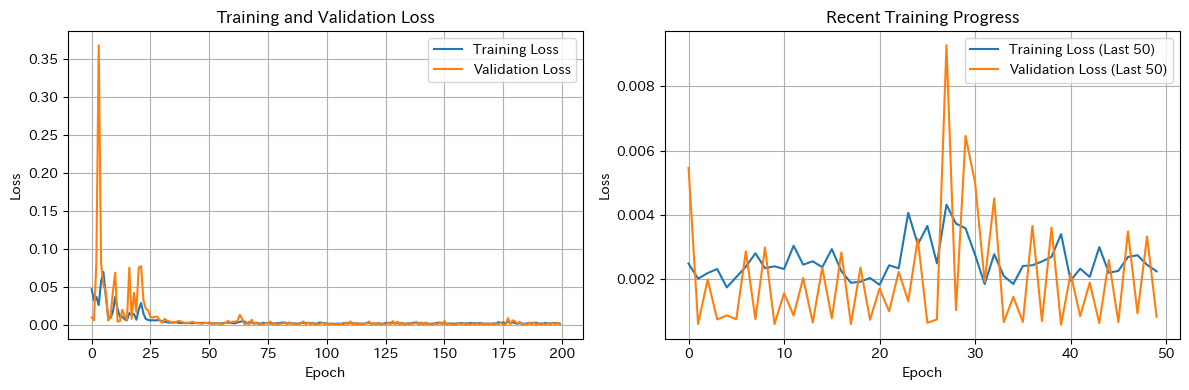

In [16]:
# 訓練履歴の可視化
def plot_training_history(train_losses, val_losses):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(train_losses[-50:], label='Training Loss (Last 50)')
    plt.plot(val_losses[-50:], label='Validation Loss (Last 50)')
    plt.title('Recent Training Progress')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


# ベストモデルの読み込み
model.load_state_dict(torch.load('best_stock_model.pth'))

# 訓練履歴の可視化
plot_training_history(train_losses, val_losses)


## テストデータでの評価

テストデータでの評価 ...

=== 予測精度の評価指標 ===
MSE:    25.7613
RMSE: 5.0756
MAE:   3.7558
MAPE: 1.87%


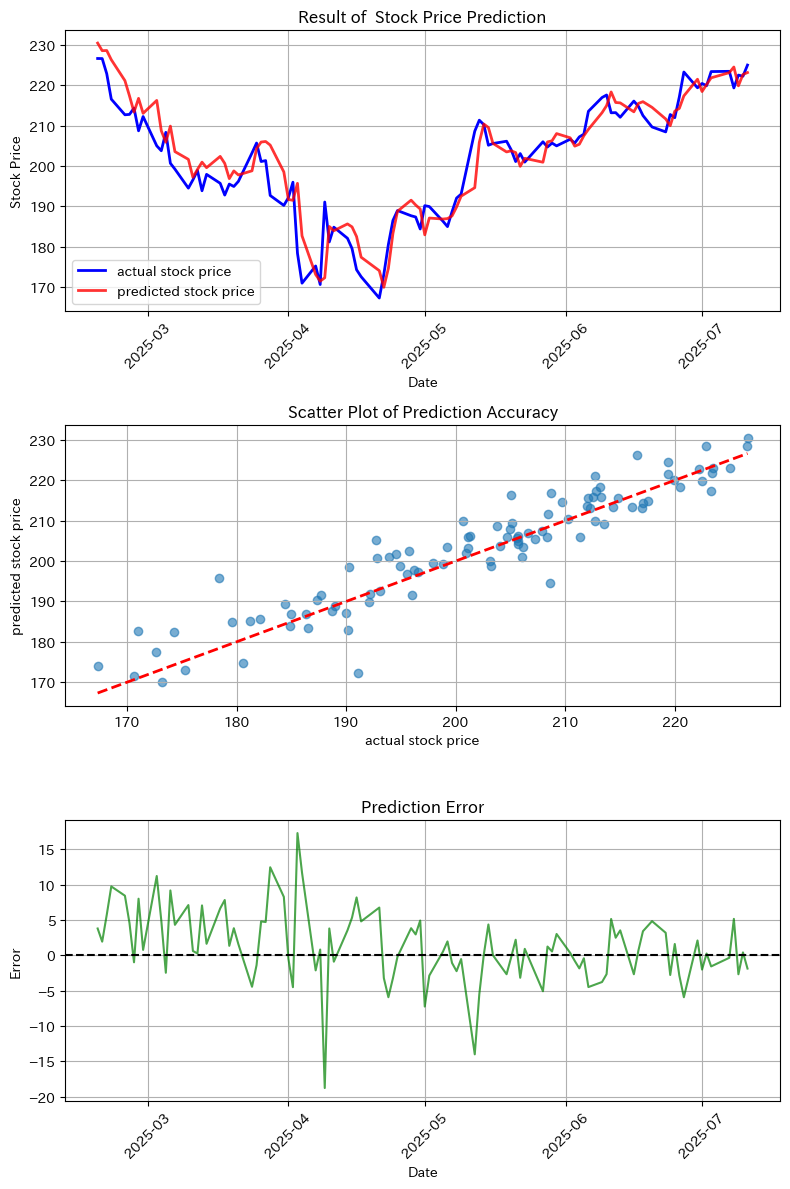

In [17]:
import matplotlib.pyplot as plt

# 予測結果の可視化
def plot_predictions(results, dates, num_points=100):
    predictions = results['predictions']
    actuals = results['actuals']

    # 最後のnum_points個のデータを表示
    if len(predictions) > num_points:
        predictions = predictions[-num_points:]
        actuals = actuals[-num_points:]
        dates = dates[-num_points:]

    plt.figure(figsize=(8, 12))

    # メインプロット
    plt.subplot(3, 1, 1)
    plt.plot(dates, actuals, label='actual stock price', color='blue', linewidth=2)
    plt.plot(dates, predictions, label='predicted stock price', color='red', linewidth=2, alpha=0.8)
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.title('Result of  Stock Price Prediction')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)

    # 散布図
    plt.subplot(3, 1, 2)
    plt.scatter(actuals, predictions, alpha=0.6)
    plt.plot([actuals.min(), actuals.max()], [actuals.min(), actuals.max()], 'r--', lw=2)
    plt.xlabel('actual stock price')
    plt.ylabel('predicted stock price')
    plt.title('Scatter Plot of Prediction Accuracy')
    plt.grid(True)

    # 誤差分析
    plt.subplot(3, 1, 3)
    errors = predictions - actuals
    plt.plot(dates, errors, color='green', alpha=0.7)
    plt.axhline(y=0, color='black', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Error')
    plt.title('Prediction Error')
    plt.grid(True)
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

# テストデータでの評価
print("テストデータでの評価 ...")

results = evaluate_model(model, test_loader, processor.scaler)

# 評価指標の表示
print("\n=== 予測精度の評価指標 ===")
print(f"MSE:    {results['mse']:.4f}")
print(f"RMSE: {results['rmse']:.4f}")
print(f"MAE:   {results['mae']:.4f}")
print(f"MAPE: {results['mape']:.2f}%")

# 結果の可視化
plot_predictions(results, test_dates[sequence_length:])